In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

dataset = pd.read_csv("Social_Network_Ads.csv")
dataset

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


In [2]:
dataset = dataset.drop("User ID", axis = 1)
dataset = pd.get_dummies(dataset, drop_first = True, dtype = int)
dataset.columns

Index(['Age', 'EstimatedSalary', 'Purchased', 'Gender_Male'], dtype='object')

In [3]:
independent = dataset.drop(columns = ['Purchased'])
dependent = dataset[['Purchased']]
dependent.value_counts()

Purchased
0            257
1            143
Name: count, dtype: int64

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
x_scaled = scaler.fit_transform(independent)

x_train, x_test, y_train, y_test = train_test_split(independent, dependent, test_size = 0.30, random_state = 0) 
x_train, x_test, y_train, y_test

(     Age  EstimatedSalary  Gender_Male
 92    26            15000            1
 223   60           102000            1
 234   38           112000            0
 232   40           107000            1
 377   42            53000            0
 ..   ...              ...          ...
 323   48            30000            0
 192   29            43000            1
 117   36            52000            1
 47    27            54000            0
 172   26           118000            0
 
 [280 rows x 3 columns],
      Age  EstimatedSalary  Gender_Male
 132   30            87000            1
 309   38            50000            0
 341   35            75000            1
 196   30            79000            0
 246   35            50000            0
 ..   ...              ...          ...
 216   49            65000            1
 259   45           131000            0
 49    31            89000            0
 238   46            82000            0
 343   47            51000            0
 
 [120 rows 

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model_name, model, X_test, y_test, y_prob):
    print(f"\n==================== {model_name} ====================")
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    clf_report = classification_report(y_test, y_pred)

    print(f"Accuracy: {acc:.2f}")
    print("Confusion Matrix:\n", cm)
    print("Classification report:\n", clf_report)
    print(f"AUC Score: {auc:.2f}")

    # Confusion Matrix Heatmap
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
from sklearn.naive_bayes import (
    GaussianNB, 
    BernoulliNB, 
    MultinomialNB, 
    ComplementNB, 
    CategoricalNB
)
from sklearn.model_selection import GridSearchCV


==================== GaussianNB ====================
Accuracy: 0.89
Confusion Matrix:
 [[74  5]
 [ 8 33]]
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92        79
           1       0.87      0.80      0.84        41

    accuracy                           0.89       120
   macro avg       0.89      0.87      0.88       120
weighted avg       0.89      0.89      0.89       120

AUC Score: 0.96


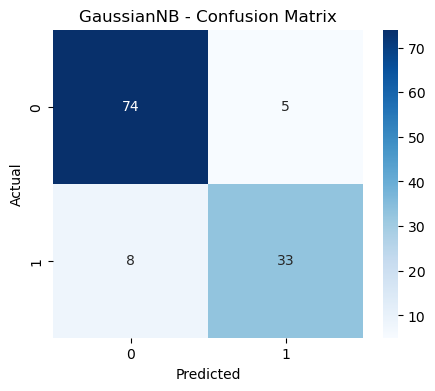

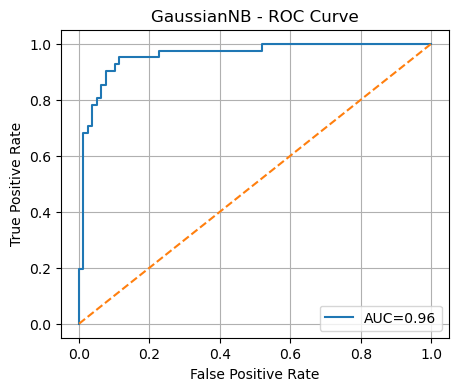

In [19]:
# GaussianNB has no hyperparameters to tune
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_prob = gnb.predict_proba(x_test)[:, 1]
evaluate_model("GaussianNB", gnb, x_test, y_test, y_prob)


Best BernoulliNB Params: {'alpha': 0.1, 'binarize': 70000}

==================== BernoulliNB (GridSearch) ====================
Accuracy: 0.63
Confusion Matrix:
 [[49 30]
 [14 27]]
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.62      0.69        79
           1       0.47      0.66      0.55        41

    accuracy                           0.63       120
   macro avg       0.63      0.64      0.62       120
weighted avg       0.67      0.63      0.64       120

AUC Score: 0.64


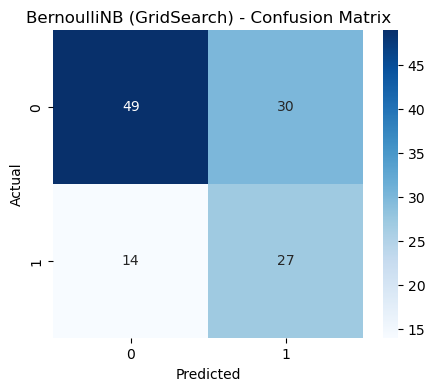

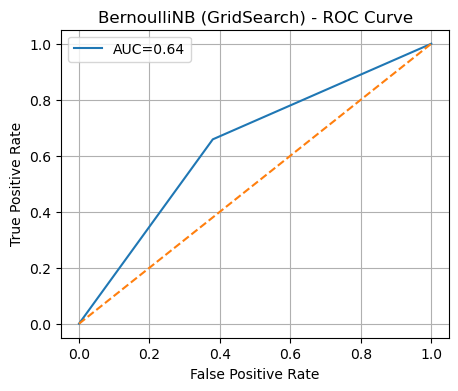

In [20]:
#Has alpha, binarize
bnb = BernoulliNB()

param_grid_bnb = {
    'alpha': [0.1, 0.5, 1.0],
    'binarize': [30000, 50000, 70000]
}

grid_bnb = GridSearchCV(
    estimator = bnb,
    param_grid = param_grid_bnb,
    cv = 3,
    scoring = 'roc_auc'
)

from imblearn.over_sampling import RandomOverSampler
#Using Random Oversampling for Oversample the minority class
ros = RandomOverSampler(random_state=0)
x_train_res, y_train_res = ros.fit_resample(x_train, y_train)

grid_bnb.fit(x_train_res, y_train_res)
best_bnb = grid_bnb.best_estimator_
print("\nBest BernoulliNB Params:", grid_bnb.best_params_)

y_prob = best_bnb.predict_proba(x_test)[:, 1]
evaluate_model("BernoulliNB (GridSearch)", best_bnb, x_test, y_test, y_prob)


Best MultinomialNB Params: {'alpha': 0.1}

==================== MultinomialNB (GridSearch) ====================
Accuracy: 0.68
Confusion Matrix:
 [[68 11]
 [28 13]]
Classification report:
               precision    recall  f1-score   support

           0       0.71      0.86      0.78        79
           1       0.54      0.32      0.40        41

    accuracy                           0.68       120
   macro avg       0.62      0.59      0.59       120
weighted avg       0.65      0.68      0.65       120

AUC Score: 0.52


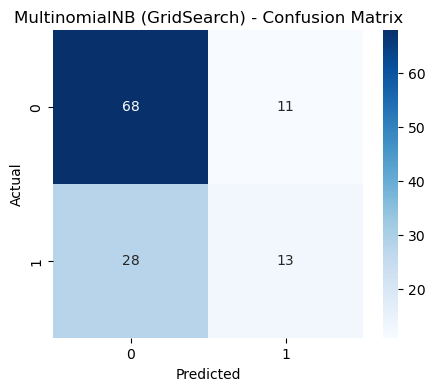

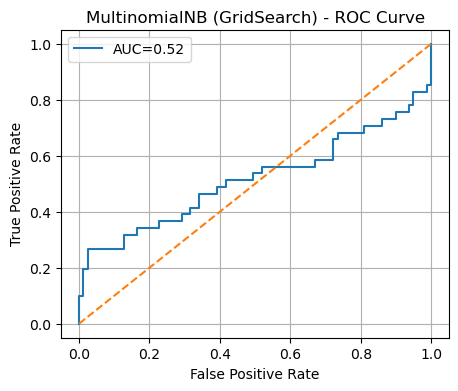

In [21]:
#Has alpha
mnb = MultinomialNB()

param_grid_mnb = {
    'alpha': [0.1, 0.5, 1.0]
}

grid_mnb = GridSearchCV(
    estimator = mnb,
    param_grid = param_grid_mnb,
    cv = 3,
    scoring = 'roc_auc'
)

grid_mnb.fit(x_train, y_train)
best_mnb = grid_mnb.best_estimator_
print("\nBest MultinomialNB Params:", grid_mnb.best_params_)

y_prob = best_mnb.predict_proba(x_test)[:, 1]
evaluate_model("MultinomialNB (GridSearch)", best_mnb, x_test, y_test, y_prob)


Best ComplementNB Params: {'alpha': 0.1}

==================== ComplementNB (GridSearch) ====================
Accuracy: 0.53
Confusion Matrix:
 [[42 37]
 [20 21]]
Classification report:
               precision    recall  f1-score   support

           0       0.68      0.53      0.60        79
           1       0.36      0.51      0.42        41

    accuracy                           0.53       120
   macro avg       0.52      0.52      0.51       120
weighted avg       0.57      0.52      0.54       120

AUC Score: 0.52


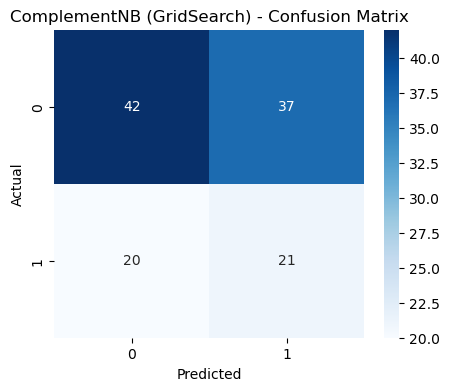

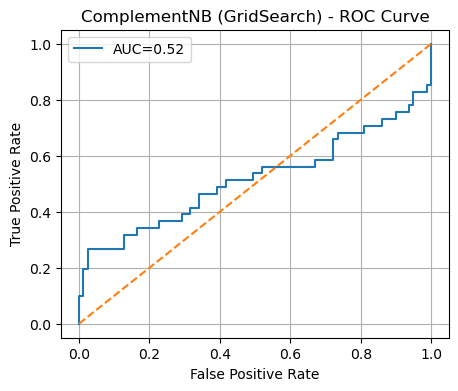

In [22]:
#Has alpha
cnb = ComplementNB()

param_grid_cnb = {
    'alpha': [0.1, 0.5, 1.0]
}

grid_cnb = GridSearchCV(
    estimator=cnb,
    param_grid=param_grid_cnb,
    cv=3,
    scoring='roc_auc'
)

grid_cnb.fit(x_train, y_train)
best_cnb = grid_cnb.best_estimator_
print("\nBest ComplementNB Params:", grid_cnb.best_params_)

y_prob = best_cnb.predict_proba(x_test)[:, 1]
evaluate_model("ComplementNB (GridSearch)", best_cnb, x_test, y_test, y_prob)


Best CategoricalNB Params: {'alpha': 0.1}

==================== CategoricalNB (GridSearch) ====================
Accuracy: 0.82
Confusion Matrix:
 [[69 10]
 [11 30]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.87        79
           1       0.75      0.73      0.74        41

    accuracy                           0.82       120
   macro avg       0.81      0.80      0.80       120
weighted avg       0.82      0.82      0.82       120

AUC Score: 0.88


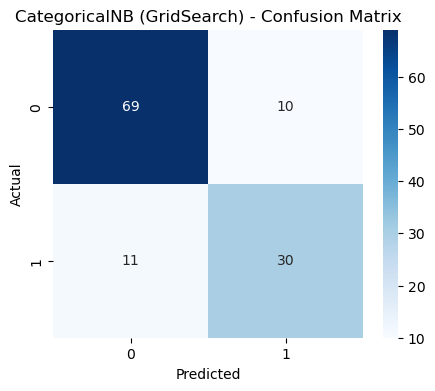

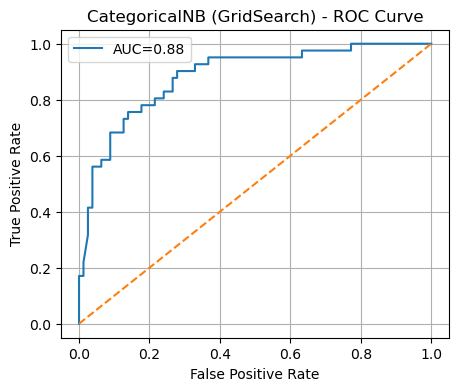

In [23]:
#Has alpha
catnb = CategoricalNB()

param_grid_catnb = {
    'alpha': [0.1, 0.5, 1.0]
}

grid_catnb = GridSearchCV(
    estimator=catnb,
    param_grid=param_grid_catnb,
    cv=3,
    scoring='roc_auc'
)

grid_catnb.fit(x_train, y_train)
best_catnb = grid_catnb.best_estimator_
print("\nBest CategoricalNB Params:", grid_catnb.best_params_)

y_prob = best_catnb.predict_proba(x_test)[:, 1]
evaluate_model("CategoricalNB (GridSearch)", best_catnb, x_test, y_test, y_prob)

In [24]:
# Sample Prediction (Using GaussianNB as baseline)

input = [[32, 85000, 0]]   # Age, Salary, gender
prediction = gnb.predict(input)
print("Sample Input:", input)
print("Predicted Output:", prediction[0])

Sample Input: [[32, 85000, 0]]
Predicted Output: 0
